In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

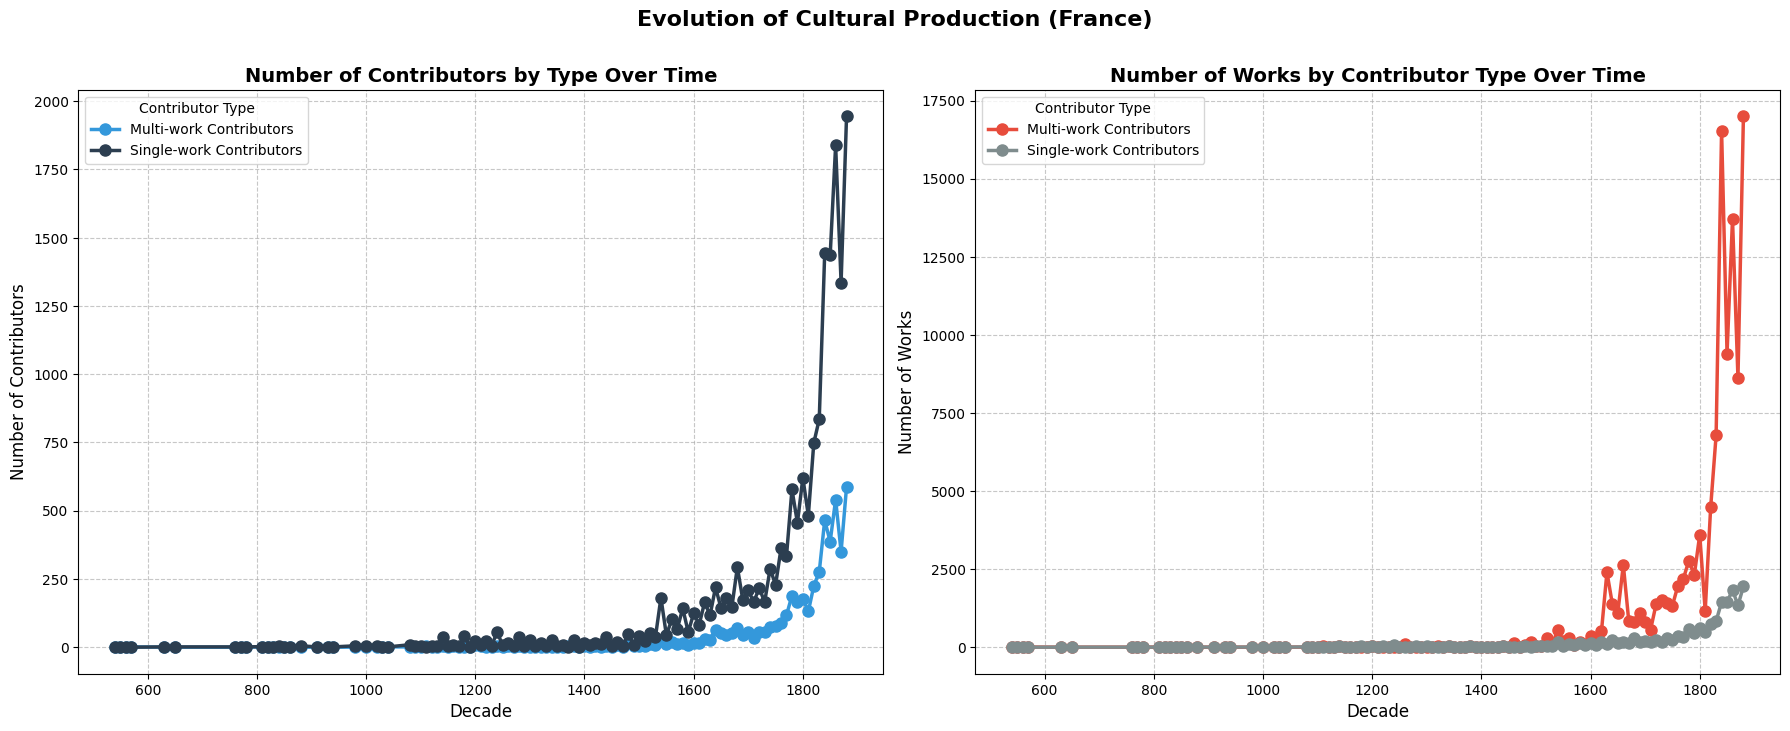

In [2]:
df = pd.read_csv('../3 - unseen_species_index/unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col=[0])


# Starting with your code
sample_test = df[df['region_name']=='France']
sample_test = sample_test[['individual_wikidata_id','decade', 'count_works']].drop_duplicates()
sample_test = sample_test.reset_index(drop=True)
# sample_test = sample_test[sample_test['count_works']!=0]


sample_test['count_works'][sample_test['count_works']==0] = 1

# Classify contributors as single-work or multi-work
contributor_work_counts = sample_test.groupby(['decade', 'individual_wikidata_id'])['count_works'].sum().reset_index()
contributor_work_counts['contributor_type'] = contributor_work_counts['count_works'].apply(
    lambda x: 'Single-work Contributors' if x == 1 else 'Multi-work Contributors')

# Aggregate by decade and contributor type
decade_contributor_analysis = contributor_work_counts.groupby(['decade', 'contributor_type']).agg(
    unique_contributors=('individual_wikidata_id', 'nunique'),
    total_works=('count_works', 'sum')
).reset_index()

# Pivot the data for plotting
contributors_pivot = decade_contributor_analysis.pivot(
    index='decade', columns='contributor_type', values='unique_contributors').fillna(0)
works_pivot = decade_contributor_analysis.pivot(
    index='decade', columns='contributor_type', values='total_works').fillna(0)

# Make sure both contributor types are present in the pivoted data
for pivot_df in [contributors_pivot, works_pivot]:
    if 'Single-work Contributors' not in pivot_df.columns:
        pivot_df['Single-work Contributors'] = 0
    if 'Multi-work Contributors' not in pivot_df.columns:
        pivot_df['Multi-work Contributors'] = 0

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Graph 1: Number of unique contributors by type over time
contributors_pivot.plot(kind='line', marker='o', ax=ax1, 
                       color=['#3498db', '#2c3e50'], linewidth=2.5, markersize=8)
ax1.set_title('Number of Contributors by Type Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Decade', fontsize=12)
ax1.set_ylabel('Number of Contributors', fontsize=12)
ax1.legend(title='Contributor Type')
ax1.grid(True, linestyle='--', alpha=0.7)

# Graph 2: Number of works produced by contributor type over time
works_pivot.plot(kind='line', marker='o', ax=ax2, 
                color=['#e74c3c', '#7f8c8d'], linewidth=2.5, markersize=8)
ax2.set_title('Number of Works by Contributor Type Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Decade', fontsize=12)
ax2.set_ylabel('Number of Works', fontsize=12)
ax2.legend(title='Contributor Type')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a descriptive caption
fig.suptitle('Evolution of Cultural Production (France)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.15)
plt.show()


